## Tests:
here we will explore tests of various concepts used in the parellel robot optimization project interactively

### can a linear transformation change the ordering of the vertecies of a polygon? 

our first point, is that changing the order of the polygon vertecies will disturb the calculation of the area of overlap, as shown below

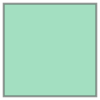

In [105]:
from shapely.geometry import Polygon
import numpy as np
p1 = Polygon(((0,0),(1,0),(1,1),(0,1)))
p1

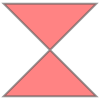

In [5]:
p2 = Polygon(((0,0),(1,1),(0,1),(1,0)))
p2

so you can see, depending on the order of the points, you can create either a convex, or self intersecting polygon, and the area's are different, and of course, the area's of overlap with another polygon would be different as well

In [10]:
print("p1 area = ", p1.area)
print("p2 area = ", p2.area)

p1 area =  1.0
p2 area =  0.0


so, we want to test using Monte-carlo methods if a polygon that has a valid point ordering can be transformed into a self intersecting polygon through a linear transformation. If it can't (which I suspect) then we never need to make a call to convex hull again, at least for 2D to 2D mapping cases

In [91]:
pts = np.array([[0,1,1,0],[0,0,1,1]])
truthArr = []
truthArr2 = []
for i in range(10):
    jac = (np.random.random((2,2)) - .5) * 2
    if np.linalg.cond(jac) < 100:
        pts_new = (jac @ pts).T
        verts = [(pts_new[i,0], pts_new[i,1]) for i in range(pts_new.shape[0])]
        poly = Polygon(verts)
        truthArr.append(poly.is_valid)
        truthArr2.append(poly.convex_hull.area - poly.area < 1e-9)

In [94]:
False in truthArr or False in truthArr2

False

this proves that we do not need to check for the convex hull of a polygon after a linear transformation, as it's points will always have a valid ordering. this can likely be proven via linear algebra first principles

### Designing the decay functions for the Simulated Annealing algorithm

in simulated Annealing for the optimization of continuous variables, there are two decay functions that need to be set. The first is the rate at which the Temperature parameter changes, and the second, is a function for control of the neighborhood size from which the next sample is selected. to a first approximation, both of these functions can be exponential decay functions in nature, although the could in theory, have multiple restarts, periods where the temperature is held constant, etc. 

In this investigation, I'm experimentally looking into the difference between a discrete time exponential decay, and a continuous time exponential decay, and showing that they may be tuned such that the discrete time system represents a sampled version of the continuous time system.  I will then formulate the systems interms of trial based half-lives, as i believe that this is the most intuitive way to think about theses time constants, when tuning them for the performance of the simulated Anealing algorithm. 


#### show equivalence of multiple representations of the same exponential decay function

I believe that the method for showing equivalence between the two types of systems will come through the change of base formula:

<img src="./imgs/changeOfBase.gif" style="width:100px">

from the change of base formula, it can be seen that:

$$ x(k) = x_0a^k $$

which may be expressed recursively as: 

$$ x(k+1) = ax(k)$$

is equivalent to:

$$ x(k) = x_0e^{k\ln(a)} $$

this is proven below with a test case


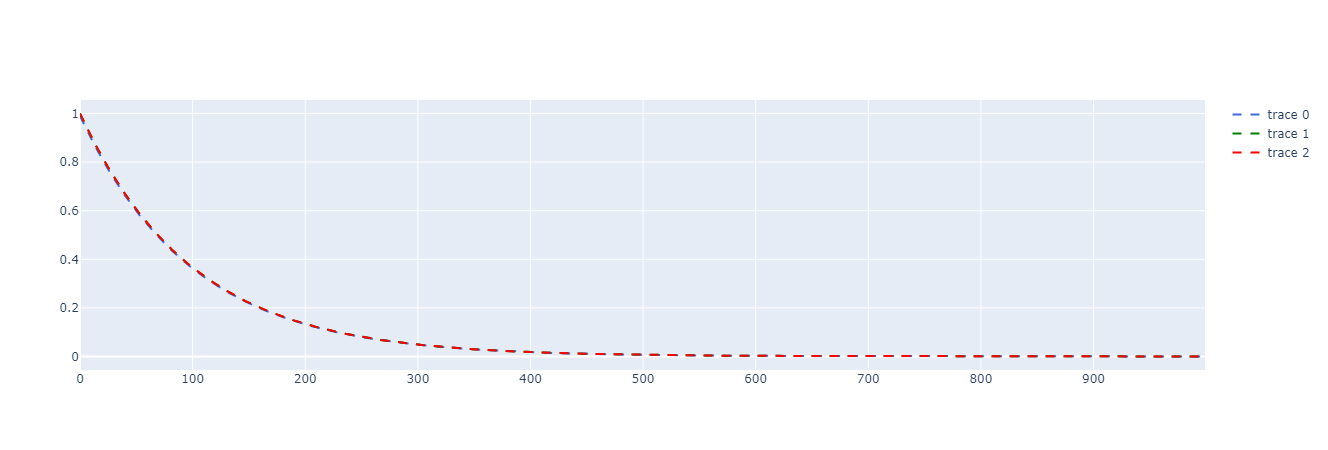

In [96]:
import plotly.graph_objs as go
import numpy as np

#initialize
x0 = 1
a = .99
yr = x0  #recursive solution
y1 = []
y2 = []
y3 = []


#calculate
for k in range(1000):
    yr = yr * a
    y1.append(yr)
    y2.append(x0 * a**k)
    y3.append(x0*np.exp(k*np.log(a)))

    
#plot    
xs = np.arange(0,1000,1)
fig = go.Figure()
fig.add_scatter(x=xs,y=y1,line=dict(dash='dash',color='royalblue'))
fig.add_scatter(x=xs,y=y2,line=dict(dash='dash',color='green'))
fig.add_scatter(x=xs,y=y3,line=dict(dash='dash',color='red'))

no doubt then, these are all the same function. 

### formulate in terms of trial half-life

next, we will build the function in the for where the half-life may be specified in terms of trial number, as this is the most useful parameterization for the Simulated Annealing 
algorithm. of the equivalent forms of exponential decay, the one most useful for formultion in terms of half-life, rather than time constant $\tau$ is:

$$N(k) = N_0.5^{(k/k_{1/2})}$$

where $k_{1/2}$ is the trial half-life

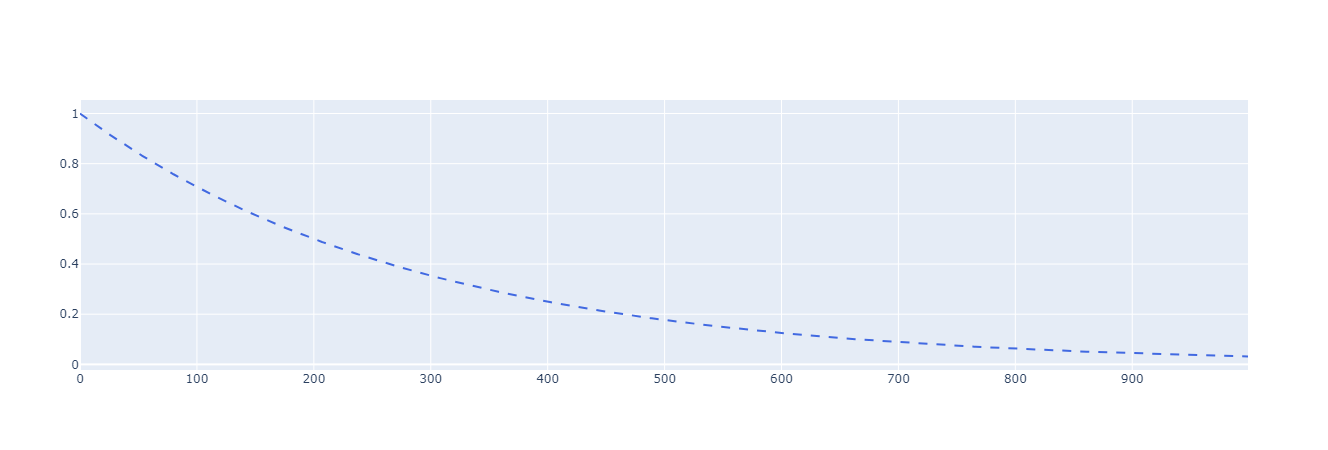

In [100]:
import plotly.graph_objs as go
import numpy as np


#discrete time exponential function
N0 = 1
kHalf = 200
ks = np.arange(0,1000,1)
Ns = []

for k in ks:
    Ns.append(N0*.5**(k/kHalf))

fig = go.Figure()
fig.add_scatter(x=xs,y=Ns,line=dict(dash='dash',color='royalblue'))

This is the right approach

### Next question